# Exercise 5: Generative Models - VAE and Diffusion

---

> **Reinforcement Learning** in Winter Semester 2025/2026
>
> - Prof. Gerhard Neumann and Prof. Rudolf Lioutikov
> - Instructor for this exercise: Hongyi Zhou (hongyi.zhou@kit.edu)
> 
> ⚠️ For general questions about the exercises, please post in the Ilias forum so we can answer them once for all students. Only use email for individual questions whose answers are not relevant to all students.

---

# Group Submission

The exercise sheets can be submitted in groups of up to **3 students**. **Only one member in the group is required to upload the final version via Ilias**.

Groups are automatically recorded, so **please enter the u-identifiers of your group members in the following cell.** If your group consists of only 2 students, or if you are submitting alone, leave the remaining fields empty. Here is an **example** for a group consisting of uabcd and uefgh:

_U-identifiers of group members:_

_Member 1: uabcd_

_Member 2: uefgh_

_Member 3:_

U-identifiers of group members:

Member 1: ubhqg

Member 2: urphy

Member 3:

# Auto-grading

We use an auto-grading system that automatically analyzes your submitted Jupyter Notebooks and checks them for correctness using hidden tests. These tests determine the points you receive for the exercise sheet.

To ensure auto-grading works smoothly, please note the following:

- The notebook must have the filename "ex_05_diffusion.ipynb"
- Upload Jupyter Notebook on Ilias (not as a zip!)
- Before submitting a notebook, test that everything runs without errors from start to finish.
- Cells marked with "##### DO NOT CHANGE #####" must not be edited or deleted
- Your solution must be entered in the correct cell (marked with "# YOUR CODE HERE").
  - Please delete the **NotImplementedError!**
- Generally, **do not delete any cells** and **do not add any cells**. The cells where your solution should be entered already exist (marked with "# YOUR CODE HERE").
- There may be seemingly empty cells that are also marked with "##### DO NOT CHANGE #####". These must also not be edited or deleted.
  - If you do modify them, auto-grading will not work and you will receive no points.
  - We will be strict about this and make no exceptions if someone modifies cells clearly marked as readonly!
- The Jupyter Notebooks have inline tests (visible to you) that check your result for basic correctness.
  - These are primarily for you to identify and correct errors.
  - However, the inline tests you can see in the notebook are not the tests used for grading!
  - The inline tests are a necessary but not sufficient condition to receive points when grading the task!

## Local Setup

If you prefer to work locally, see the following instructions for setting up Python in a virtual environment.
You can then ignore the instructions in "Colab Setup".

If you haven't yet, create a [conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/index.html) environment using:
```
conda create --name rl_exercises python=3.10
conda activate rl_exercises
```
Torch recommends installation using conda rather than pip, so run:
```
conda install pytorch cpuonly -c pytorch
```
If you have a CUDA-enabled GPU and would like to use it, visit [the installation page](https://pytorch.org/get-started/locally/) to see the options available for different CUDA versions.
The remaining dependencies can be installed with pip:
```
pip install matplotlib numpy tqdm
```

Even if you are running the Jupyter notebook locally, please run the code cells in **Colab Setup**, because they define some global variables required later.

## Colab Setup

Google Colab provides you with a temporary environment for python programming.
While this conveniently works on any platform and internally handles dependency issues and such, it also requires you to set up the environment from scratch every time.
The "Colab Setup" section below will be part of **every** exercise and contains utility that is needed before getting started.

There is a timeout of about ~12 hours with Colab while it is active (and less if you close your browser window).
Any changes you make to the Jupyter notebook itself should be saved to your Google Drive.
We also save all recordings and logs in it by default so that you won't lose your work in the event of an instance timeout.
However, you will need to re-mount your Google Drive and re-install packages with every new instance.

In [1]:
##### DO NOT CHANGE #####
# Colab setup - install dependencies
try:
    import google.colab
    COLAB = True
    %pip install -q matplotlib numpy tqdm torch
except ImportError:
    COLAB = False

print("Setup complete!")

##### DO NOT CHANGE #####

Setup complete!


In [2]:
##### DO NOT CHANGE #####
import math
import random
from dataclasses import dataclass
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from tqdm import tqdm, trange

from IPython.display import display, clear_output

##### DO NOT CHANGE #####

In [3]:
##### DO NOT CHANGE #####
# Reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

@dataclass
class CFG:
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    # Data (GMM)
    n_components: int = 8
    data_dim: int = 2
    gmm_radius: float = 3.0       
    gmm_std: float = 0.2          
    batch_size: int = 512
    n_train_samples: int = 20000  # samples per epoch

    # VAE
    vae_epochs: int = 100
    vae_lr: float = 1e-3
    latent_dim: int = 2
    beta_kl: float = 0.1

    # Diffusion (DDPM)
    ddpm_epochs: int = 100
    ddpm_lr: float = 1e-3
    T: int = 100
    beta_start: float = 1e-4
    beta_end: float = 0.02

    # Logging/display
    log_every: int = 30
    sample_n: int = 500

cfg = CFG()
set_seed(cfg.seed)
print("Device:", cfg.device)

##### DO NOT CHANGE #####

Device: cuda


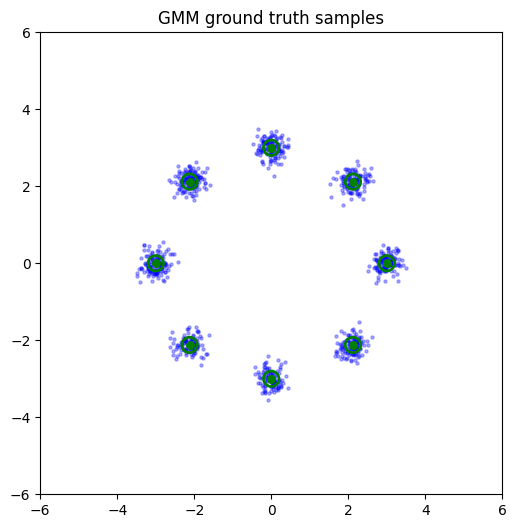

In [4]:
##### DO NOT CHANGE #####
def generate_gmm_params(n_components: int, dim: int, device: str, r: float = 1.0, std: float = 0.2):
    """
    Generate GMM parameters with components arranged in a circle.

    Args:
        n_components: number of Gaussian components
        dim: data dimension (should be 2 for circular arrangement)
        device: torch device
        r: radius of the circle where components are placed
        std: standard deviation of each component (isotropic)
    """
    # Place components evenly on a circle
    thetas = torch.linspace(0, 2 * math.pi, n_components + 1, device=device)[:-1]
    means = torch.stack([r * torch.cos(thetas), r * torch.sin(thetas)], dim=-1)
    # Isotropic covariance: identity scaled by std
    chols = torch.eye(dim, device=device).unsqueeze(0).repeat(n_components, 1, 1) * std
    return means, chols

def sample_gmm(means: torch.Tensor, chols: torch.Tensor, n_samples: int):
    """Sample from a GMM using torch.distributions."""
    n_components = means.shape[0]
    prior = torch.ones(n_components, device=means.device) / n_components
    gating = D.Categorical(prior)
    comps = D.MultivariateNormal(means, scale_tril=chols)
    gmm = D.MixtureSameFamily(gating, comps)
    return gmm.sample((n_samples,))

def plot_gaussian_ellipse(mean, chol, ax, color='green'):
    """
    Plot a Gaussian distribution as an ellipse (2 std).
    """
    # Compute covariance from Cholesky factor
    cov = chol @ chol.T
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    # Angle of the ellipse
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    # Width and height (2 standard deviations)
    width, height = 2 * np.sqrt(eigenvalues)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      alpha=1.0, fill=False, color=color, linewidth=2.0)
    ax.add_patch(ellipse)
    ax.scatter(*mean, c=color, s=30)

def show_scatter(samples: torch.Tensor, title: str = "",
                 true_means: Optional[torch.Tensor] = None,
                 true_chols: Optional[torch.Tensor] = None,
                 xlim: Optional[tuple] = None, ylim: Optional[tuple] = None):
    """Plot 2D samples as scatter plot, with GMM ellipses."""
    samples_np = samples.detach().cpu().numpy()
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.scatter(samples_np[:, 0], samples_np[:, 1], alpha=0.3, s=5, c='blue')

    if true_means is not None and true_chols is not None:
        # Draw GMM component ellipses
        means_np = true_means.detach().cpu().numpy()
        chols_np = true_chols.detach().cpu().numpy()
        for i in range(means_np.shape[0]):
            plot_gaussian_ellipse(means_np[i], chols_np[i], ax, color='green')

    # Auto-compute limits based on radius if not provided
    lim = 2 * cfg.gmm_radius
    if xlim is None:
        xlim = (-lim, lim)
    if ylim is None:
        ylim = (-lim, lim)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)
    ax.set_aspect('equal')
    plt.show()

# Generate GMM parameters
gmm_means, gmm_chols = generate_gmm_params(cfg.n_components, cfg.data_dim, cfg.device,
                                            r=cfg.gmm_radius, std=cfg.gmm_std)

# Quick peek at true data
true_samples = sample_gmm(gmm_means, gmm_chols, 1000)
show_scatter(true_samples, title="GMM ground truth samples", true_means=gmm_means, true_chols=gmm_chols)


##### DO NOT CHANGE #####

# Part 0: Why Do We Need Expressive Generative Models?

Before diving into VAEs and Diffusion models, let's see what happens when we try to fit a simple Gaussian distribution to our multi-modal GMM data using **Maximum Likelihood Estimation (MLE)**.

## Maximum Likelihood for a Gaussian

Given data $\{x_i\}_{i=1}^N$, the MLE for a Gaussian $\mathcal{N}(\mu, \Sigma)$ has closed-form solutions:

$$\hat{\mu} = \frac{1}{N} \sum_{i=1}^N x_i \qquad \text{(sample mean)}$$

$$\hat{\Sigma} = \frac{1}{N} \sum_{i=1}^N (x_i - \hat{\mu})(x_i - \hat{\mu})^\top \qquad \text{(sample covariance)}$$

Let's fit this to our 8-mode GMM data and see what happens.

MLE Mean: [-0.02767033 -0.01353446]
MLE Covariance:
[[4.514412   0.02160914]
 [0.02160914 4.5461774 ]]


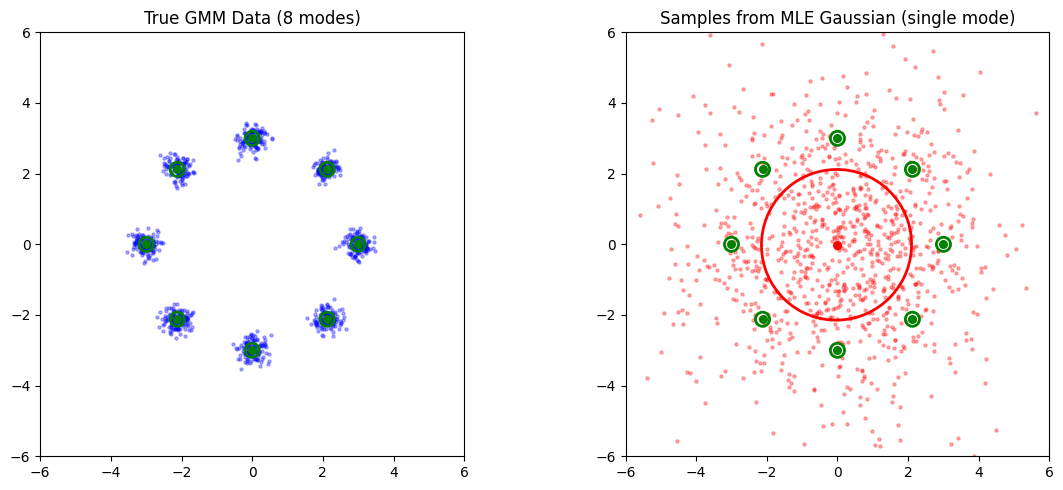

In [5]:
##### DO NOT CHANGE #####
# Fit a single Gaussian to the GMM data using MLE
train_data = sample_gmm(gmm_means, gmm_chols, 5000)

# MLE estimates
mu_mle = train_data.mean(dim=0)  # Sample mean
centered = train_data - mu_mle
cov_mle = (centered.T @ centered) / len(train_data)  # Sample covariance

print(f"MLE Mean: {mu_mle.cpu().numpy()}")
print(f"MLE Covariance:\n{cov_mle.cpu().numpy()}")

# Sample from the fitted Gaussian
fitted_gaussian = D.MultivariateNormal(mu_mle, cov_mle)
gaussian_samples = fitted_gaussian.sample((1000,))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: True data
samples_np = train_data[:1000].cpu().numpy()
axes[0].scatter(samples_np[:, 0], samples_np[:, 1], alpha=0.3, s=5, c='blue')
for i in range(gmm_means.shape[0]):
    plot_gaussian_ellipse(gmm_means[i].cpu().numpy(), gmm_chols[i].cpu().numpy(), axes[0], color='green')
axes[0].set_xlim(-2*cfg.gmm_radius, 2*cfg.gmm_radius)
axes[0].set_ylim(-2*cfg.gmm_radius, 2*cfg.gmm_radius)
axes[0].set_title("True GMM Data (8 modes)")
axes[0].set_aspect('equal')

# Right: Samples from fitted Gaussian
gaussian_np = gaussian_samples.cpu().numpy()
axes[1].scatter(gaussian_np[:, 0], gaussian_np[:, 1], alpha=0.3, s=5, c='red')
# Draw the fitted Gaussian ellipse
chol_mle = torch.linalg.cholesky(cov_mle).cpu().numpy()
plot_gaussian_ellipse(mu_mle.cpu().numpy(), chol_mle, axes[1], color='red')
# Also show true GMM for reference
for i in range(gmm_means.shape[0]):
    plot_gaussian_ellipse(gmm_means[i].cpu().numpy(), gmm_chols[i].cpu().numpy(), axes[1], color='green')
axes[1].set_xlim(-2*cfg.gmm_radius, 2*cfg.gmm_radius)
axes[1].set_ylim(-2*cfg.gmm_radius, 2*cfg.gmm_radius)
axes[1].set_title("Samples from MLE Gaussian (single mode)")
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

##### DO NOT CHANGE #####

## The Problem: Mode Collapse

As you can see, the single Gaussian completely fails to capture the multi-modal structure of the data:

1. **Mean collapse**: The MLE mean lands near the origin (center of all modes), where **no actual data exists**
2. **Over-dispersed variance**: The covariance is large to "cover" all modes, generating many samples in empty regions
3. **No mode separation**: The model cannot represent the 8 distinct clusters

This is a fundamental limitation of simple parametric distributions. Real-world data (images, audio, text) often lies on complex, multi-modal manifolds that cannot be captured by a single Gaussian.

## The Solution: Expressive Generative Models

To model complex distributions, we need more expressive approaches:

- **VAE (Part 1)**: Uses a neural network decoder to transform a simple latent distribution into a complex data distribution. The decoder learns a non-linear mapping $z \mapsto x$ that can create multi-modal outputs.

- **Diffusion Models (Part 2)**: Learns to iteratively denoise samples, effectively learning the **score function** (gradient of log-density) which can represent arbitrary distributions without explicit density estimation.

Both approaches can successfully capture all 8 modes of our GMM, as you'll see in the following sections.

# Part 1: Variational Autoencoder (VAE)

In this section, you will implement the core components of a Variational Autoencoder (VAE) for 2D data generation.

## Background

A VAE learns to encode data into a latent space and decode it back. The key components are:

1. **Encoder**: Maps input $x$ to parameters of a latent distribution: $q_\phi(z\mid x) = \mathcal{N}\!\big(\mu_\phi(x),\ \mathrm{diag}(\sigma_\phi^2(x))\big)$
2. **Reparameterization Trick**: Enables backpropagation through sampling: $z = \mu_\phi(x) + \sigma_\phi(x)\odot \epsilon $, where $\epsilon \sim \mathcal{N}(0, I)$
3. **Decoder**: Maps latent $z$ back to reconstructed data $\hat{x}$: $p_\theta(x\mid z) = \mathcal{N}\!\big(x;\ \mu_\theta(z),\ \sigma_x^2 I\big)$
4. **Loss**: Maximizing the Evidence Lower Bound (see below).

The VAE is trained by maximizing the **Evidence Lower Bound (ELBO)**:
$$
\mathcal{L}_{\mathrm{ELBO}}(\theta,\phi; x)
=
\underbrace{\mathbb{E}_{z\sim q_\phi(z\mid x)}\big[\log p_\theta(x\mid z)\big]}_{\text{reconstruction term}}
-
\underbrace{\mathrm{KL}\!\left(q_\phi(z\mid x)\,\|\,p(z)\right)}_{\text{regularization term}}
$$

In practice, we minimize the **negative ELBO**. A common $\beta$-VAE variant uses:
$$
\mathcal{J}(\theta,\phi; x)
=
-\mathbb{E}_{z\sim q_\phi(z\mid x)}\big[\log p_\theta(x\mid z)\big]
+
\beta\,\mathrm{KL}\!\left(q_\phi(z\mid x)\,\|\,p(z)\right)
$$

With the Gaussian decoder
$$
p_\theta(x \mid z) = \mathcal{N}\!\big(x;\, \mu_\theta(z),\, \sigma_x^2 I\big),
$$

the negative log-likelihood is:
$$
-\log p_\theta(x \mid z)
= \frac{1}{2\sigma_x^2}\,\|x-\mu_\theta(z)\|_2^2
+\frac{d}{2}\log(2\pi\sigma_x^2),
$$
where $d$ is the data dimension.

If $\sigma_x^2$ is fixed, the second term is constant w.r.t. $\theta$, so minimizing $-\log p_\theta(x\mid z)$ is equivalent (up to scaling) to minimizing:
$$
\|x-\mu_\theta(z)\|_2^2.
$$

This corresponds to the mean-squared error (MSE):
$$
\mathrm{MSE}(x,\hat{x})
= \frac{1}{d}\|x-\hat{x}\|_2^2,
\qquad \hat{x}=\mu_\theta(z).
$$

In [6]:
##### DO NOT CHANGE #####
class Encoder(nn.Module):
    def __init__(self, data_dim: int, latent_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
        )
        self.mu = nn.Linear(64, latent_dim)
        self.logvar = nn.Linear(64, latent_dim)

    def forward(self, x):
        h = self.net(x)
        return self.mu(h), self.logvar(h)

class Decoder(nn.Module):
    def __init__(self, latent_dim: int, data_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, data_dim)
        )

    def forward(self, z):
        return self.net(z)

##### DO NOT CHANGE #####

## Task 1.1: Reparameterization Trick (2 pts)

Implement the reparameterization trick for the VAE. The encoder defines an approximate posterior

$$
q_\phi(z\mid x)=\mathcal N\!\big(\mu_\phi(x),\,\mathrm{diag}(\sigma_\phi^2(x))\big).
$$

To sample $z\sim q_\phi(z\mid x)$ while keeping the computation differentiable w.r.t. $\phi$, sample noise

$$
\epsilon \sim \mathcal N(0,I)
$$

and construct

$$
z=\mu_\phi(x)+\sigma_\phi(x)\odot \epsilon,
$$

where $\odot$ denotes elementwise multiplication.

**Implementation note (log-variance):** the encoder outputs

$$
\text{logvar}(x)=\log \sigma_\phi^2(x),
$$

so compute

$$
\sigma_\phi(x)=\exp\!\left(\tfrac{1}{2}\,\text{logvar}(x)\right).
$$

**Hints:**
- Use `torch.exp()` to compute the standard deviation from log-variance
- Use `torch.randn_like(mu)` to sample noise $\epsilon$ with the same shape as `mu`

In [ ]:
def reparameterize(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    """
    Implement the reparameterization trick for VAE.
    
    Parameters:
        mu (torch.Tensor): Mean of the latent distribution, shape (B, latent_dim)
        logvar (torch.Tensor): Log variance of the latent distribution, shape (B, latent_dim)
    
    Returns:
        torch.Tensor: Sampled latent vector z, shape (B, latent_dim)
    """
    # YOUR CODE HERE
    raise NotImplementedError()
    return z

In [ ]:
##### DO NOT CHANGE #####
# Visible tests for Task 1.1
print("Testing reparameterize...")
SEED = 42

torch.manual_seed(SEED)
_test_mu = torch.randn(32, 4)
_test_logvar = torch.randn(32, 4)
_test_z = reparameterize(_test_mu, _test_logvar)

# Shape check
assert _test_z.shape == _test_mu.shape, f"Output shape {_test_z.shape} should match input shape {_test_mu.shape}"

# z should not be exactly equal to mu (randomness)
assert not torch.allclose(_test_z, _test_mu), "z should not equal mu (sampling should add noise)"

# Check that output is not NaN
assert not torch.isnan(_test_z).any(), "Output should not contain NaN values"

print("Visible tests passed!")

##### DO NOT CHANGE #####

In [ ]:
##### DO NOT CHANGE #####
# ID: cell-72967c1093381a9c - possible points: 2



##### DO NOT CHANGE #####

## Task 1.2: KL Divergence (2 pts)

Implement the KL divergence between the encoder's approximate posterior and the standard normal prior:

$$
q_\phi(z\mid x)=\mathcal N\!\big(\mu_\phi(x),\,\mathrm{diag}(\sigma_\phi^2(x))\big),
\qquad
p(z)=\mathcal N(0,I).
$$

The encoder outputs the log-variance

$$
\text{logvar}(x)=\log \sigma_\phi^2(x)
\quad\Longrightarrow\quad
\sigma_\phi^2(x)=\exp(\text{logvar}(x)).
$$

The closed-form KL (diagonal Gaussian vs. standard normal) is:

$$
\mathrm{KL}\!\left(q_\phi(z\mid x)\,\|\,p(z)\right)
=
\frac{1}{2}\sum_{j=1}^{d_z}
\left(
\mu_{\phi,j}(x)^2
+
\exp(\text{logvar}_j(x))
-
1
-
\text{logvar}_j(x)
\right),
$$

where $d_z$ is the latent dimension.

**Return:** the KL divergence **per sample**, i.e., sum over latent dimensions (do not average over the batch).

**Hints:**
- Use `torch.exp()` to compute variance from log-variance
- Use `torch.sum(..., dim=1)` to sum over latent dimensions while keeping the batch dimension

In [ ]:
def kl_divergence_diag_gaussian(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    """
    Compute KL divergence between q(z|x) = N(mu, diag(exp(logvar))) and p(z) = N(0, I).
    
    Parameters:
        mu (torch.Tensor): Mean, shape (B, latent_dim)
        logvar (torch.Tensor): Log variance, shape (B, latent_dim)
    
    Returns:
        torch.Tensor: KL divergence per sample, shape (B,)
    """
    # YOUR CODE HERE
    raise NotImplementedError()
    return kl


In [ ]:
##### DO NOT CHANGE #####
# Visible tests for Task 1.2
print("Testing kl_divergence_diag_gaussian...")

# KL(N(0,I) || N(0,I)) should be 0
_mu_zero = torch.zeros(16, 4)
_logvar_zero = torch.zeros(16, 4)  # variance = 1
_kl_zero = kl_divergence_diag_gaussian(_mu_zero, _logvar_zero)
assert torch.allclose(_kl_zero, torch.zeros(16), atol=1e-6), "KL(N(0,I) || N(0,I)) should be 0"

# KL should be positive for non-standard distributions
_mu_nonzero = torch.randn(16, 4)
_logvar_nonzero = torch.randn(16, 4)
_kl_nonzero = kl_divergence_diag_gaussian(_mu_nonzero, _logvar_nonzero)
assert (_kl_nonzero >= 0).all(), "KL divergence should be non-negative"

# Shape check
assert _kl_nonzero.shape == (16,), f"Output shape should be (B,), got {_kl_nonzero.shape}"

print("Visible tests passed!")

##### DO NOT CHANGE #####

In [ ]:
##### DO NOT CHANGE #####
# ID: cell-a70a5db27da5644b - possible points: 2



##### DO NOT CHANGE #####

## Task 1.3: VAE Loss Function (2 pts)

Implement the (negative) ELBO loss by combining the reconstruction loss (Gaussian decoder ⇒ MSE) and the KL divergence.

Let the decoder output the reconstruction mean
$$
\hat{x}_i = \mu_\theta(z_i),
\qquad
z_i \sim q_\phi(z\mid x_i).
$$

Define the per-sample objective:
$$
\mathcal{J}(\theta,\phi; x_i)
=
\underbrace{\|x_i-\hat{x}_i\|_2^2}_{\text{reconstruction (MSE)}}
+
\beta\,
\underbrace{\mathrm{KL}\!\left(q_\phi(z\mid x_i)\,\|\,p(z)\right)}_{\text{regularization}}.
$$

Return the batch-averaged loss:
$$
\mathcal{J}_{\text{batch}}
=
\frac{1}{B}\sum_{i=1}^{B}
\left[
\|x_i-\hat{x}_i\|_2^2
+
\beta\,\mathrm{KL}\!\left(q_\phi(z\mid x_i)\,\|\,p(z)\right)
\right],
$$
where $B$ is the batch size and $\beta$ weights the KL term.

In [ ]:
def vae_loss(x: torch.Tensor, x_recon: torch.Tensor, 
             mu: torch.Tensor, logvar: torch.Tensor, 
             beta: float = 1.0) -> tuple:
    """
    Compute the VAE loss: Reconstruction Loss + beta * KL Divergence.
    
    Parameters:
        x (torch.Tensor): Original input, shape (B, data_dim)
        x_recon (torch.Tensor): Reconstructed input, shape (B, data_dim)
        mu (torch.Tensor): Latent mean, shape (B, latent_dim)
        logvar (torch.Tensor): Latent log variance, shape (B, latent_dim)
        beta (float): Weight for KL divergence term
    
    Returns:
        tuple: (total_loss, recon_loss_mean, kl_loss_mean)
            - total_loss: scalar tensor, mean loss over batch
            - recon_loss_mean: float, mean reconstruction loss
            - kl_loss_mean: float, mean KL divergence
    
    Hint:
            - Use F.mse_loss with reduction="none" to compute per-sample reconstruction loss
            - Sum reconstruction loss over data dimensions, recon shape should be (B,)
            - Use kl_divergence_diag_gaussian to compute KL divergence per sample, kl shape should also be (B,)
    """
    # YOUR CODE HERE
    raise NotImplementedError()
    return loss, recon.mean().item(), kl.mean().item()

In [ ]:
##### DO NOT CHANGE #####
# Visible tests for Task 1.3
print("Testing vae_loss...")

torch.manual_seed(SEED)
_x = torch.randn(32, 2)
_x_recon = torch.randn(32, 2)
_mu = torch.randn(32, 4)
_logvar = torch.randn(32, 4)

_loss, _recon_mean, _kl_mean = vae_loss(_x, _x_recon, _mu, _logvar, beta=1.0)

# Loss should be a scalar
assert _loss.ndim == 0, "Loss should be a scalar"

# Loss should not be NaN
assert not torch.isnan(_loss), "Loss should not be NaN"

# With perfect reconstruction, recon loss should be near zero
_loss_perfect, _recon_perfect, _ = vae_loss(_x, _x, _mu, _logvar, beta=1.0)
assert _recon_perfect < 1e-4, "Perfect reconstruction should have near-zero recon loss"

print("Visible tests passed!")

##### DO NOT CHANGE #####

In [ ]:
##### DO NOT CHANGE #####
# ID: cell-76d267a6864f68dd - possible points: 2



##### DO NOT CHANGE #####

In [ ]:
##### DO NOT CHANGE #####
class VAE(nn.Module):
    def __init__(self, data_dim: int, latent_dim: int):
        super().__init__()
        self.enc = Encoder(data_dim, latent_dim)
        self.dec = Decoder(latent_dim, data_dim)

    def forward(self, x):
        mu, logvar = self.enc(x)
        z = reparameterize(mu, logvar)  # Uses your implementation!
        x_recon = self.dec(z)
        return x_recon, mu, logvar

@torch.no_grad()
def vae_sample(model: VAE, n: int = 64):
    z = torch.randn(n, cfg.latent_dim, device=cfg.device)
    x = model.dec(z)
    return x

##### DO NOT CHANGE #####

In [ ]:
##### DO NOT CHANGE #####
def train_vae():
    model = VAE(cfg.data_dim, cfg.latent_dim).to(cfg.device)
    opt = torch.optim.Adam(model.parameters(), lr=cfg.vae_lr)

    step = 0
    losses = []
    recon_losses = []
    kl_losses = []
    
    # Setup for dynamic plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    display_handle = display(fig, display_id=True)
    
    model.train()
    for epoch in range(cfg.vae_epochs):
        # Sample fresh data each epoch
        data = sample_gmm(gmm_means, gmm_chols, cfg.n_train_samples)

        for i in range(0, len(data), cfg.batch_size):
            x = data[i:i+cfg.batch_size]
            x_recon, mu, logvar = model(x)
            loss, recon_m, kl_m = vae_loss(x, x_recon, mu, logvar, beta=cfg.beta_kl)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            losses.append(loss.item())
            recon_losses.append(recon_m)
            kl_losses.append(kl_m)
            step += 1

        # Only clear loss plot axes (not the sample plot)
        axes[0].clear()
        axes[1].clear()
        
        # Plot total loss
        axes[0].plot(losses, 'b-', alpha=0.7)
        axes[0].set_title(f"Total Loss (epoch {epoch+1}/{cfg.vae_epochs})")
        axes[0].set_xlabel("step")
        axes[0].set_ylabel("loss")
        axes[0].grid(True, alpha=0.3)
        
        # Plot reconstruction and KL losses
        axes[1].plot(recon_losses, 'g-', alpha=0.7, label='Recon')
        axes[1].plot(kl_losses, 'r-', alpha=0.7, label='KL')
        axes[1].set_title("Recon & KL Loss")
        axes[1].set_xlabel("step")
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Plot samples only every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == 0:
            axes[2].clear()
            model.eval()
            xs = vae_sample(model, n=cfg.sample_n)
            samples_np = xs.detach().cpu().numpy()
            axes[2].scatter(samples_np[:, 0], samples_np[:, 1], alpha=0.3, s=5, c='blue')
            means_np = gmm_means.detach().cpu().numpy()
            chols_np = gmm_chols.detach().cpu().numpy()
            for j in range(means_np.shape[0]):
                plot_gaussian_ellipse(means_np[j], chols_np[j], axes[2], color='green')
            lim = 2 * cfg.gmm_radius
            axes[2].set_xlim(-lim, lim)
            axes[2].set_ylim(-lim, lim)
            axes[2].set_aspect('equal')
            axes[2].set_title(f"VAE Samples (epoch {epoch+1})")
            model.train()
        
        fig.tight_layout()
        display_handle.update(fig)
    
    plt.close(fig)
    
    # Final visualization
    model.eval()
    xs = vae_sample(model, n=cfg.sample_n)
    show_scatter(xs, title=f"VAE final samples (epoch {cfg.vae_epochs})", true_means=gmm_means, true_chols=gmm_chols)

    return model, losses

##### DO NOT CHANGE #####

## Run VAE Training

Run the cell below to train the VAE. You should see the samples gradually improve and cover the 8 GMM modes.

In [ ]:
##### DO NOT CHANGE #####
vae_model, vae_losses = train_vae()

##### DO NOT CHANGE #####


# Part 2: Denoising Diffusion Probabilistic Model (DDPM)

In this section, you will implement the core components of a Denoising Diffusion Probabilistic Model (DDPM) for 2D data generation. The notations here might be slightly different from the lectures, we adopted the notations from the DDPM original paper https://arxiv.org/pdf/2006.11239

## Background

DDPM learns to reverse a gradual noising process:

### Forward Process (Adding Noise)

Given a noise schedule $\beta_1, \ldots, \beta_T$ and defining $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$:

$$q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t)I)$$

This means we can sample $x_t$ directly from $x_0$:
$$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)$$

### Reverse Process (Denoising)

The model learns to predict the noise $\epsilon$ that was added at each step. Given the predicted noise $\epsilon_\theta(x_t, t)$, the reverse step computes:

$$\mu_\theta = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right)$$

Then sample the previous state as:

$$x_{t-1} = \mu_\theta + \sigma_t z, \quad z \sim \mathcal{N}(0, I)$$

where $\sigma_t = \sqrt{\beta_t}$ (for $t > 0$, no noise at $t = 0$). Noise is added during most reverse steps to keep sampling stochastic.

In [ ]:
##### DO NOT CHANGE #####
def linear_beta_schedule(T: int, beta_start: float, beta_end: float, device: str):
    return torch.linspace(beta_start, beta_end, T, device=device)

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, t: torch.Tensor):
        """
        t: (B,) int64 timesteps in [0, T-1]
        returns: (B, dim)
        """
        half = self.dim // 2
        freqs = torch.exp(
            torch.linspace(0, math.log(10000), half, device=t.device) * (-1)
        )
        args = t.float().unsqueeze(1) * freqs.unsqueeze(0)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0, 1))
        return emb

class ScoreMLP(nn.Module):
    """
    MLP for 2D noise prediction with time conditioning.
    """
    def __init__(self, data_dim: int = 2, time_dim: int = 128, hidden_dim: int = 256):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalTimeEmbedding(time_dim),
            nn.Linear(time_dim, time_dim), nn.SiLU(),
            nn.Linear(time_dim, time_dim),
        )

        self.net = nn.Sequential(
            nn.Linear(data_dim + time_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, data_dim)
        )

    def forward(self, x, t):
        """
        x: (B, data_dim)
        t: (B,) int64
        """
        temb = self.time_mlp(t)  # (B, time_dim)
        h = torch.cat([x, temb], dim=1)  # (B, data_dim + time_dim)
        return self.net(h)

##### DO NOT CHANGE #####

In [ ]:
##### DO NOT CHANGE #####
class DDPM:
    def __init__(self, T: int, beta_start: float, beta_end: float, device: str, data_dim: int = 2):
        self.device = device
        self.T = T
        self.data_dim = data_dim

        self.betas = linear_beta_schedule(T, beta_start, beta_end, device)
        self.alphas = 1.0 - self.betas
        self.alphabars = torch.cumprod(self.alphas, dim=0)

        # Precompute some handy terms
        self.sqrt_alphabars = torch.sqrt(self.alphabars)
        self.sqrt_one_minus_alphabars = torch.sqrt(1.0 - self.alphabars)

##### DO NOT CHANGE #####

## Task 2.1: Forward Diffusion Process (3 pts)

Implement the forward diffusion process that samples $x_t$ directly from $x_0$:

$$x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon$$

**Hints:**
- Use `self.sqrt_alphabars` and `self.sqrt_one_minus_alphabars` which are precomputed
- Use `.gather(0, t)` to index into the schedule tensors by timestep
- Reshape the gathered values to `(-1, 1)` using `.view(-1, 1)` for broadcasting with the batch dimension
- Use `torch.randn_like(x0)` to sample noise $\epsilon$ if not provided

In [ ]:
def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):
    """
    Forward diffusion: sample x_t directly from x_0.
    
    x_t = sqrt(alphabar_t) * x_0 + sqrt(1 - alphabar_t) * epsilon
    
    Parameters:
        x0: Clean data, shape (B, data_dim)
        t: Timesteps, shape (B,) with values in [0, T-1]
        eps: Pre-sampled noise (optional), shape (B, data_dim)
    
    Returns:
        tuple: (x_t, eps) where x_t is the noised data
    
    """
    if eps is None:
        eps = torch.randn_like(x0)
    
    # YOUR CODE HERE
    raise NotImplementedError()
    return xt, eps

# Attach method to DDPM class
DDPM.q_sample = q_sample

In [ ]:
##### DO NOT CHANGE #####
# Visible tests for Task 2.1
print("Testing q_sample...")

_ddpm_test = DDPM(T=100, beta_start=1e-4, beta_end=0.02, device="cpu", data_dim=2)

torch.manual_seed(SEED)
_x0 = torch.randn(16, 2)
_t = torch.randint(0, 100, (16,))
_xt, _eps = _ddpm_test.q_sample(_x0, _t)

# Shape check
assert _xt.shape == _x0.shape, f"x_t shape {_xt.shape} should match x_0 shape {_x0.shape}"
assert _eps.shape == _x0.shape, f"eps shape {_eps.shape} should match x_0 shape {_x0.shape}"

# At t=0, x_t should be very close to x_0 (alphabar_0 is close to 1)
_t_zero = torch.zeros(16, dtype=torch.long)
_xt_zero, _ = _ddpm_test.q_sample(_x0, _t_zero)
assert torch.allclose(_xt_zero, _x0, atol=0.05), "At t=0, x_t should be very close to x_0"

print("Visible tests passed!")

##### DO NOT CHANGE #####

In [ ]:
##### DO NOT CHANGE #####
# ID: cell-9836155d5c3b5b32 - possible points: 3



##### DO NOT CHANGE #####

## Task 2.2: Reverse Diffusion Step (3 pts)

Implement one reverse step $x_t \rightarrow x_{t-1}$ using the DDPM update rule:

1. Predict the noise: $\epsilon_\theta = \text{model}(x_t, t)$
2. Compute the mean: $\mu = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta \right)$
3. Add noise (except at $t=0$): $x_{t-1} = \mu + \sqrt{\beta_t} \cdot z$ where $z \sim \mathcal{N}(0, I)$

**Hints:**
- Use `self.betas`, `self.alphas`, `self.alphabars` indexed by `t` with `.gather(0, t).view(-1, 1)`
- Use `torch.sqrt()` for computing $\sqrt{\alpha_t}$, $\sqrt{1-\bar{\alpha}_t}$, and $\sigma_t = \sqrt{\beta_t}$
- Use `torch.randn_like(xt)` to sample noise $z$
- Use `torch.where(condition, x, y)` to handle the $t=0$ case (no noise added)
- Create the mask for $t=0$ using `(t == 0).view(-1, 1)` for proper broadcasting

In [ ]:
@torch.no_grad()
def p_sample(self, model: nn.Module, xt: torch.Tensor, t: torch.Tensor):
    """
    One reverse step x_t -> x_{t-1} using eps-prediction DDPM update.
    
    Parameters:
        model: Noise prediction network that takes (x, t) and returns predicted noise
        xt: Noisy data at timestep t, shape (B, data_dim)
        t: Current timesteps, shape (B,)
    
    Returns:
        x_{t-1}: Denoised data, shape (B, data_dim)
    """
    # YOUR CODE HERE
    raise NotImplementedError()
    return xprev

# Attach method to DDPM class
DDPM.p_sample = p_sample

In [ ]:
##### DO NOT CHANGE #####
# Visible tests for Task 2.2
print("Testing p_sample...")

_ddpm_test = DDPM(T=100, beta_start=1e-4, beta_end=0.02, device="cpu", data_dim=2)
_model_test = ScoreMLP(data_dim=2, time_dim=64, hidden_dim=64)

torch.manual_seed(SEED)
_xt = torch.randn(16, 2)
_t = torch.randint(1, 100, (16,))  # t > 0
_xprev = _ddpm_test.p_sample(_model_test, _xt, _t)

# Shape check
assert _xprev.shape == _xt.shape, f"Output shape {_xprev.shape} should match input shape {_xt.shape}"

# Output should not be NaN
assert not torch.isnan(_xprev).any(), "Output should not contain NaN values"

# At t=0, output should be deterministic (test by running twice with same seed)
_t_zero = torch.zeros(16, dtype=torch.long)
torch.manual_seed(123)
_xprev_zero_1 = _ddpm_test.p_sample(_model_test, _xt, _t_zero)
torch.manual_seed(456)  # Different seed
_xprev_zero_2 = _ddpm_test.p_sample(_model_test, _xt, _t_zero)
assert torch.allclose(_xprev_zero_1, _xprev_zero_2), "At t=0, output should be deterministic (no noise)"

print("Visible tests passed!")

##### DO NOT CHANGE #####

In [ ]:
##### DO NOT CHANGE #####
# ID: cell-4398d200e70a35ba - possible points: 3



##### DO NOT CHANGE #####

In [ ]:
##### DO NOT CHANGE #####
@torch.no_grad()
def ddpm_sample(self, model: nn.Module, n: int = 64):
    model.eval()
    x = torch.randn(n, self.data_dim, device=self.device)  # x_T ~ N(0, I)
    for ti in reversed(range(self.T)):
        t = torch.full((n,), ti, device=self.device, dtype=torch.long)
        x = self.p_sample(model, x, t)
    return x

DDPM.sample = ddpm_sample

##### DO NOT CHANGE #####

In [ ]:
##### DO NOT CHANGE #####
def train_ddpm():
    ddpm = DDPM(cfg.T, cfg.beta_start, cfg.beta_end, cfg.device, cfg.data_dim)
    model = ScoreMLP(data_dim=cfg.data_dim, time_dim=128, hidden_dim=256).to(cfg.device)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.ddpm_lr)

    step = 0
    losses = []
    
    # Setup for dynamic plotting
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    display_handle = display(fig, display_id=True)
    
    model.train()
    for epoch in range(cfg.ddpm_epochs):
        # Sample fresh data each epoch
        data = sample_gmm(gmm_means, gmm_chols, cfg.n_train_samples)

        for i in range(0, len(data), cfg.batch_size):
            x0 = data[i:i+cfg.batch_size]

            # sample timesteps uniformly
            t = torch.randint(0, cfg.T, (x0.size(0),), device=cfg.device, dtype=torch.long)

            xt, eps = ddpm.q_sample(x0, t)
            eps_pred = model(xt, t)

            # MSE loss on epsilon prediction
            loss = F.mse_loss(eps_pred, eps)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            losses.append(loss.item())
            step += 1

        # Only clear the loss plot axis (not the sample plot)
        axes[0].clear()
        
        # Plot loss curve
        axes[0].plot(losses, 'b-', alpha=0.7)
        axes[0].set_title(f"DDPM Loss (epoch {epoch+1}/{cfg.ddpm_epochs})")
        axes[0].set_xlabel("step")
        axes[0].set_ylabel("MSE loss")
        axes[0].grid(True, alpha=0.3)
        
        # Plot samples only every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == 0:
            axes[1].clear()
            model.eval()
            xs = ddpm.sample(model, n=cfg.sample_n)
            samples_np = xs.detach().cpu().numpy()
            axes[1].scatter(samples_np[:, 0], samples_np[:, 1], alpha=0.3, s=5, c='blue')
            means_np = gmm_means.detach().cpu().numpy()
            chols_np = gmm_chols.detach().cpu().numpy()
            for j in range(means_np.shape[0]):
                plot_gaussian_ellipse(means_np[j], chols_np[j], axes[1], color='green')
            lim = 2 * cfg.gmm_radius
            axes[1].set_xlim(-lim, lim)
            axes[1].set_ylim(-lim, lim)
            axes[1].set_aspect('equal')
            axes[1].set_title(f"DDPM Samples (epoch {epoch+1})")
            model.train()
        
        fig.tight_layout()
        display_handle.update(fig)
    
    plt.close(fig)
    
    # Final visualization
    model.eval()
    xs = ddpm.sample(model, n=cfg.sample_n)
    show_scatter(xs, title=f"DDPM final samples (epoch {cfg.ddpm_epochs})", true_means=gmm_means, true_chols=gmm_chols)

    return model, ddpm, losses

##### DO NOT CHANGE #####

## Run DDPM Training

Run the cell below to train the DDPM. You should see the samples gradually improve and cover the 8 GMM modes.

In [ ]:
##### DO NOT CHANGE #####
ddpm_model, ddpm_obj, ddpm_losses = train_ddpm()

##### DO NOT CHANGE #####

## Self-test questions (No Points)

1. What is the purpose of the reparameterization trick in VAEs? Why can't we just sample z directly?


2. In the VAE loss, what happens if beta (the KL weight) is set very high? Very low?


3. How does the number of diffusion steps $T$ affect sample quality and sampling speed? What are the trade-offs?


4. Compare VAE and DDPM: What are the trade-offs between these two generative models in terms of training, sampling, and sample quality?